# Data Volume By Latitude

Finds the data volume for ICESat-2 Products by latitude or 10 km by 10 km grids.

In [1]:
import earthaccess
import h5py
import numpy as np

from pyproj import CRS, Transformer
from shapely.geometry import Polygon, box
import geopandas as gpd

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from sliderule import sliderule, icesat2

from data_by_latitude import GridCell, transformer, get_global_grid_size, EASEGridGlobal100km

## Divide Globe into 10 km by 10 km grids

How we do this depends on whether we querying a global dataset or a polar dataset.

### Calculate Grids for Global Dataset

In [2]:
xmin, ymin, xmax, ymax = EASEGridGlobal100km.grid_bounds
xmin, ymin, xmax, ymax

(-17367530.445161372,
 -7428885.855155732,
 17367530.445161372,
 7228105.156367739)

In [3]:
ease_global = CRS.from_epsg(6933)
wgs84 = CRS.from_epsg(4326)
wgs84_geod = wgs84.get_geod()
wgs84_to_ease = transformer(wgs84, ease_global)

The circumference of the WGS84 ellipsoid is 40075.017 km.  So grid boxes cannot be a round number of kilometers.  The equator can be spanned by almost 4000 10 km by 10 km grid boxes.  So I divide the length of the equator by 4000 to get the exact size of grid boxes.

In [4]:
ex, ey = wgs84_to_ease.transform(0., 180.)
length_of_equator = 2*ex
mx, my = wgs84_to_ease.transform(86., 0.)
length_of_meridian = 2 * my

ncol = np.floor(ex/100000) * 2  # Calculate so that there is an equal number of cells in each hemisphere
width = length_of_equator / ncol
height = width
nrow = np.floor(my / height)

print(f"Length of equator: {length_of_equator} m")
print(f"Length of meridian: {length_of_meridian} m")

print(f"Number of 100 km cells on equator: {ncol}")
print(f"nrow: {nrow}")
print(f"width: {width}")
print(f"height: {-1*height}")
print(f"upper_left_x: {-1*ex} m")
print(f"upper_left_y: {height * nrow} m")

Length of equator: 34735060.890322745 m
Length of meridian: 14648369.127248153 m
Number of 100 km cells on equator: 346.0
nrow: 72.0
width: 100390.34939399637
height: -100390.34939399637
upper_left_x: -17367530.445161372 m
upper_left_y: 7228105.156367739 m


In [8]:
dx, dy = get_global_grid_size(wgs84.ellipsoid, nominal_cell_size=100)
dx, dy

(100187.54171394622, 100187.54171394622)

In [9]:
y / dy

-73.27359967471145

20037508.342789244

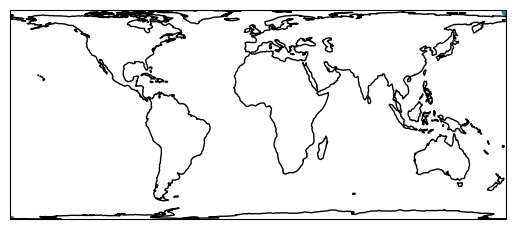

In [6]:
# Calculate locations for gridlines based on grid size.
# - first get distance from equator to pole to calculate y-locations
length_of_equator = 2 * wgs84.ellipsoid.semi_major_metre * np.pi
equator_to_pole = wgs84_geod.line_length([0., 0.], [0., 90.])

# For plotting, use 1000 km grid
# yloc = np.concatenate((
#     np.arange(-1*equator_to_pole, 0., dy),
#     np.arange(0., equator_to_pole, dy)
# ))
# xloc = np.arange(-1.*length_of_equator/2., length_of_equator/2., dx)

projection = ccrs.epsg(6933)
fig = plt.figure()
ax = fig.add_subplot(projection=projection)
ax.coastlines()

ax.scatter([xmin, xmax], [ymin,ymax], transform=projection)

# ax.gridlines(projection, xlocs=xloc, ylocs=yloc)

### Get corners of grid box

## Define Grid Cell

This defines a grid cell object that has a region property

In [2]:
dx, dy = 10000, 10000
r, c = (2, 4)
scale = 10
gridcell = GridCell(c*dx, r*dy, dx, dy, crs=6933)
print(gridcell.geometry)

POLYGON ((500000 200000, 500000 300000, 400000 300000, 400000 200000, 500000 200000))


In [4]:
gridcell.to_crs(4326)

In [5]:
gridcell.region

[{'lon': 1.5679167463159287, 'lat': 5.1820839056064045},
 {'lon': 2.352232476395504, 'lat': 5.1820839056064045},
 {'lon': 2.352232476395504, 'lat': 4.145667124485125},
 {'lon': 1.5679167463159287, 'lat': 4.145667124485125},
 {'lon': 1.5679167463159287, 'lat': 5.1820839056064045}]

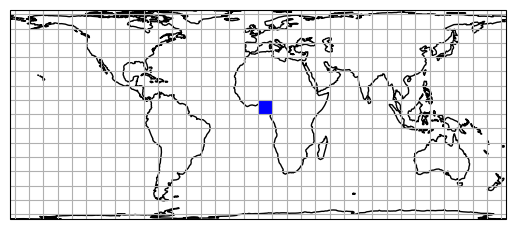

In [38]:
# Calculate locations for gridlines based on grid size.
# - first get distance from equator to pole to calculate y-locations
equator_to_pole = wgs84_geod.line_length([0., 0.], [0., 90.])

# For plotting, use 1000 km grid
yloc = np.concatenate((
    np.arange(-1*equator_to_pole, 0., dy*100.),
    np.arange(0., equator_to_pole, dy*100)
))
xloc = np.arange(-1.*length_of_equator/2., length_of_equator/2., dx*100)

projection = ccrs.epsg(6933)
fig = plt.figure()
ax = fig.add_subplot(projection=projection)
ax.coastlines()

ax.set_global()

ax.add_geometries([gridcell.geometry], projection, facecolor="blue")

# ax.scatter([0.], [0.], transform=ccrs.PlateCarree())

ax.gridlines(projection, xlocs=xloc, ylocs=yloc)

In [39]:
gridcell.to_crs(4326)

In [40]:
gridcell.xy

[(0.0, 10.383604949162219),
 (7.877468190866626, 10.383604949162219),
 (7.877468190866626, 0.0),
 (0.0, 0.0),
 (0.0, 10.383604949162219)]

In [7]:
# Build Region of Interest for testing
# region = sliderule.toregion('grandmesa.geojson')


In [8]:
region["poly"]

[{'lon': -108.20772968780051, 'lat': 38.8232055291981},
 {'lon': -108.07460164311031, 'lat': 38.8475137825863},
 {'lon': -107.72839858755752, 'lat': 39.01510930230633},
 {'lon': -107.78724142490994, 'lat': 39.195630349659986},
 {'lon': -108.17287000970857, 'lat': 39.15920066396116},
 {'lon': -108.31168256553767, 'lat': 39.13757646212944},
 {'lon': -108.34115668325224, 'lat': 39.03758987613325},
 {'lon': -108.2878686387796, 'lat': 38.89051431295789},
 {'lon': -108.20772968780051, 'lat': 38.8232055291981}]

In [11]:
parms = {
    "poly": region["poly"],  #gridcell.region,
    "cycle": 16,
}

gdf = icesat2.atl03sp(parms)
len(gdf)

2315119

In [ ]:
gdf.loc[::100].explore()

In [140]:
region["poly"]

[{'lon': -108.20772968780051, 'lat': 38.8232055291981},
 {'lon': -108.07460164311031, 'lat': 38.8475137825863},
 {'lon': -107.72839858755752, 'lat': 39.01510930230633},
 {'lon': -107.78724142490994, 'lat': 39.195630349659986},
 {'lon': -108.17287000970857, 'lat': 39.15920066396116},
 {'lon': -108.31168256553767, 'lat': 39.13757646212944},
 {'lon': -108.34115668325224, 'lat': 39.03758987613325},
 {'lon': -108.2878686387796, 'lat': 38.89051431295789},
 {'lon': -108.20772968780051, 'lat': 38.8232055291981}]

In [10]:
# Build ATL03 Subsetting Request Parameters
parms = {
    "poly": region["poly"],
    # "rgt": 737,
    "cycle": 16,
    # "srt": icesat2.SRT_LAND,
    # "cnf": icesat2.CNF_SURFACE_HIGH,
    # "len": 20.0,
    # "res": 20.0
}

# Make ATL03 Subsetting Request
atl03 = icesat2.atl03sp(parms)

In [151]:
atl03.head()

,track,cycle,segment_dist,solar_elevation,region,sc_orient,rgt,background_rate,pair,segment_id,...,height,landcover,snowcover,yapc_score,atl03_cnf,x_atc,quality_ph,y_atc,geometry,spot
time,,,,,,,,,,,,,,,,,,,,,
2022-07-05 17:55:20.563975936,3,16,1.571504e+07,66.309395,6,1,211,1.439888e+06,0,784596,...,3090.876953,255,255,0,2,-17.892048,0,2436.104492,POINT (-107.77142 39.14714),2
2022-07-05 17:55:20.564075776,3,16,1.571504e+07,66.309395,6,1,211,1.439888e+06,0,784596,...,3098.501465,255,255,0,2,-17.195995,0,2436.058350,POINT (-107.77142 39.14713),2
2022-07-05 17:55:20.564475648,3,16,1.571504e+07,66.309395,6,1,211,1.439888e+06,0,784596,...,3086.698730,255,255,0,2,-14.319958,0,2436.139404,POINT (-107.77142 39.1471),2
2022-07-05 17:55:20.564875776,3,16,1.571504e+07,66.309395,6,1,211,1.439888e+06,0,784596,...,3092.110107,255,255,0,2,-11.480976,0,2436.112061,POINT (-107.77142 39.14708),2
2022-07-05 17:55:20.564975616,3,16,1.571504e+07,66.309395,6,1,211,1.439888e+06,0,784596,...,3096.315674,255,255,0,2,-10.777695,0,2436.087402,POINT (-107.77142 39.14707),2


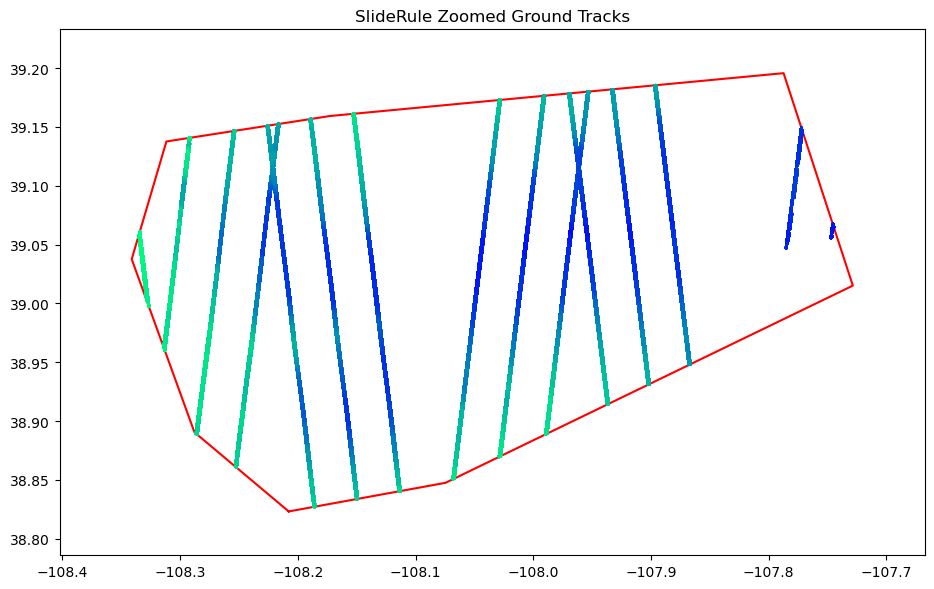

In [152]:
# Calculate Extent
lons = [p["lon"] for p in region["poly"]]
lats = [p["lat"] for p in region["poly"]]
lon_margin = (max(lons) - min(lons)) * 0.1
lat_margin = (max(lats) - min(lats)) * 0.1

# Create Plot
fig,ax = plt.subplots(num=None, ncols=1, figsize=(12, 6))
box_lon = [e["lon"] for e in region["poly"]]
box_lat = [e["lat"] for e in region["poly"]]

# Plot SlideRule Ground Tracks
ax.set_title("SlideRule Zoomed Ground Tracks")
atl03.plot(ax=ax, column=atl03["height"], cmap='winter_r', s=1.0, zorder=3)
ax.plot(box_lon, box_lat, linewidth=1.5, color='r', zorder=2)
ax.set_xlim(min(lons) - lon_margin, max(lons) + lon_margin)
ax.set_ylim(min(lats) - lat_margin, max(lats) + lat_margin)
ax.set_aspect('equal', adjustable='box')

# Show Plot
plt.tight_layout()

In [173]:
gridcell.geometry.bounds

(0.0, 0.0, 0.7853571543771051, 1.038360494916222)

In [170]:
cycle=16
segment=1   # 1 to 14
results = earthaccess.search_data(
    short_name="ATL03",
    bounding_box=gridcell.geometry.bounds,
    version="007",
    granule_name=f"ATL03_*_????{cycle:02d}{segment:02d}_*_*.h5",
    cloud_hosted=True,
)

In [171]:
len(results)

12

In [172]:
[r.data_links() for r in results]

[['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/07/04/ATL03_20220704103243_01911607_007_01.h5'],
 ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/07/04/ATL03_20220704103945_01911608_007_01.h5'],
 ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/07/16/ATL03_20220716220159_03821601_007_01.h5'],
 ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/07/20/ATL03_20220720214638_04421614_007_01.h5'],
 ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/07/20/ATL03_20220720215340_04431601_007_01.h5'],
 ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/08/02/ATL03_20220802090847_06331607_007_01.h5'],
 ['https://data.nsidc.earthdatacloud.nasa.gov/nsidc-cumulus-prod-protected/ATLAS/ATL03/007/2022/08/02/ATL03_20220802091549_0633160